<a href="https://colab.research.google.com/github/letizia-z/surgical-text-classifier-workshop/blob/main/surgical_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

| Name & Surname | Course | Academic Year    |
| :---         |    :---:   |          ---: |
| *Letizia Zanetti*   | Advanced Digital Humanities Workshop | *2024/2025*   |

# ***PROCEDURAL KNOWLEDGE CLASSIFIER FOR SURGICAL TEXTS***

## *PROJECT DESCRIPTION*
The goal of this project is to develop a classifier using `fastText` to distinguish between descriptive sentences and sentences describing operative actions (procedural actions), specifically within the domain of surgical texts. This distinction is fundamental for the management of procedural knowledge, allowing it to be structured in an organized and more easily accessible manner.

The project is inspired by concepts covered in class and the article *“Into the Single Cell Multiverse: an End-to-End Dataset for Procedural Knowledge Extraction in Biomedical Texts”*, which explores similar approaches to text classification.



### Other Sources

|Name|URL|
| :---        |    :---  |
|*Automatic Detection of Procedural Knowledge in Robotic-Assisted Surgical Texts*|[*PubMed*](https://pubmed.ncbi.nlm.nih.gov/33886045/)|
|*Automatic Extraction and Representation of Procedural Knowledge from Maintenance Manuals*|[*Mendeley*](https://data.mendeley.com/datasets/mppr364p7s/2)|
|*Into the Single Cell Multiverse: an End-to-End Dataset for Procedural Knowledge Extraction in Biomedical Texts*|[*ArXiv*](https://arxiv.org/abs/2309.01812)|



---

# 1. INTRODUCTION
In this notebook, we will address the following phases:

1. **Preprocessing:** we will structure the training data based on procedural and non-procedural sentences
2. **Training:** we will train the classification model using fastText
3. **Performance Evaluation:** we will assess the model's accuracy in distinguishing between actions and descriptions
4. **Comparison:** we will see how dataset size and distribution play a role not only in performance results but also in the inner workings of fastText itself

> *Our **ultimate goal** is therefore twofold: it is not only about creating a **robust and reusable model** for the extraction of operative sentences in surgical texts, but also about gaining practical experience with fastText by addressing **typical issues** such as datasets that are too small or imbalanced.*



---


# 2. PREPROCESSING

First off, we install the latest version of `fastText` (~65 seconds) which we use to train our model.

In [1]:
!pip install --quiet "numpy<2.0" "pandas<2.2.0" # Simulate the environment of 2024
!pip install --quiet fasttext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 96.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.1.4 which is incompatible.
xarray 2025.12.0 requires pandas>=2.2, but you have pandas 2.1.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires pandas>=2.2, but you have pandas 2.1.4 which is incompatible.
plotnine 0.14.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
mizani 0.13.5 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.


Next, we load the dataset of interest (in our case, an `.xlsx` file) into a Pandas dataframe, while also cleaning and/or modifying the content to ensure compatibility with fastText.

> **Dataset:** *Bombieri M, Rospocher M, Dall'Alba D, Fiorini P. Automatic detection of procedural knowledge in robotic-assisted surgical texts. Int J Comput Assist Radiol Surg. 2021;16(8):1287-1295. doi:[10.1007/s11548-021-02370-9](https://link.springer.com/article/10.1007/s11548-021-02370-9)*
>
> **Data Privacy Note:** The surgical dataset used in this project is restricted and available only upon request to the authors. To maintain clinical confidentiality while demonstrating the technical workflow, the data is processed in a local environment. Consequently, only the table headers and representative samples (`df.head()`) are displayed here to showcase the classification pipeline and data structure.

In [2]:
import pandas as pd

df = pd.read_excel('IJCARS_all.xlsx')
df.head()

,label,sentence
0,NON-PROCEDURAL,This stage of the procedure involves dissecti...
1,NON-PROCEDURAL,It can be performed initially or after bladde...
2,NON-PROCEDURAL,Of importance is complete or partial removal ...
3,PROCEDURAL,"If performed initially, an incision is made i..."
4,NON-PROCEDURAL,This starting point often can be confirmed by...


In this case, the provided file is already quite clean and consists only of columns relevant to our analysis. Nevertheless, the following preprocessing steps were implemented to ensure the dataset is **fully optimized** for the fastText architecture:

- **Format Conversion:** Migrated the data from .xlsx to .csv to facilitate a more efficient ingestion process.
- **Dimensionality Reduction:** Created a reduced dataframe (`df_red`) by isolating the specific target columns (`[:,col]`). This step is critical to prevent any *numerical instability* during the training phase, resulting in NaN (Not a Number) outputs.
- **Regex Sanitization:** Leveraged regular expressions to strip newline (`\n`) and tab (`\t`) characters. This prevents the classifier from misinterpreting whitespace as structural delimiters.



In [3]:
# Modify the data according to fastText's standards
import csv

col = ['label', 'sentence']
df_red = df.loc[:,col]
df['label']=['__label__'+ s for s in df.loc[:,'label']]
df['sentence'] = df.loc[:,'sentence'].replace('\n',' ', regex=True).replace('\t',' ', regex=True)
df.to_csv('IJCARS_all.csv', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar='', escapechar=' ')

df.head()

,label,sentence
0,__label__NON-PROCEDURAL,This stage of the procedure involves dissecti...
1,__label__NON-PROCEDURAL,It can be performed initially or after bladde...
2,__label__NON-PROCEDURAL,Of importance is complete or partial removal ...
3,__label__PROCEDURAL,"If performed initially, an incision is made i..."
4,__label__NON-PROCEDURAL,This starting point often can be confirmed by...


In the preceding block, the `df.to_csv` function is configured with specific parameters to ensure the output is perfectly formatted for fastText ingestion:

- `IJCARS_all.csv`: Specifies the filename for the exported dataset.
- `index=False`: Suppresses the inclusion of the row index column.
- `sep=' '`: Defines a whitespace as the delimiter between columns (instead of the standard CSV comma) to meet fastText requirements.
- `header=False`: Excludes column headers/titles from the final output.
- `quoting=csv.QUOTE_NONE`: Prevents the addition of quotation marks around text fields.
- `quotechar=''`: Uses an empty string as the quote character to correctly handle cases where quotes are part of the original text.
- `escapechar=' '`: Sanitizes the text by replacing special characters with a whitespace, ensuring clean and consistent tokenization during model training.

Finally, prior to model training, it is essential to evaluate the class **distribution** within the dataset, in that it directly influences the model's predictive behavior and the subsequent interpretation of performance metrics.

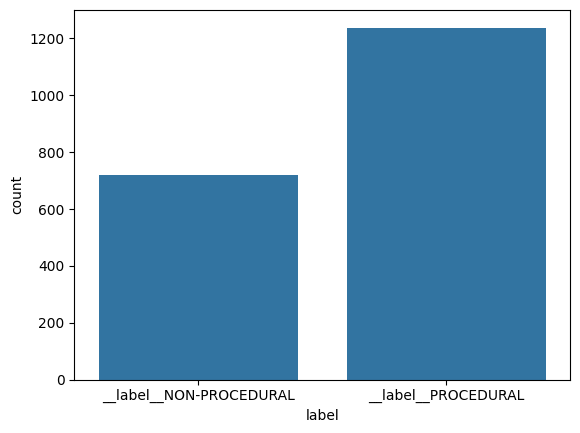

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['label'])
plt.show()

> *In this case we notice that the distribution is **slightly skewed** towards PROCEDURAL sentences. Therefore, we expect better performance with this label (see section 4).*



---


# 3. TRAINING

We are now ready to proceed to the training phase. First, we must partition the dataset into two subsets:

- **Training Set** (80%)
- **Test Set** (20%): Defined by `test_size=0.2`

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=.2, stratify=df['label'])

> ***Note on Imbalance:** Given that the dataset exhibits a slight class imbalance, we utilize the `stratify` parameter during the split to maintain the integrity of the 80/20 proportion for each individual label across both subsets.*

In [6]:
# Ensure the resulting files are correctly structured according to fastText requirements
df_train.to_csv('IJCARS.train', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar='', escapechar=' ')
df_test.to_csv('IJCARS.test', index=False, sep=' ', header=False, quoting=csv.QUOTE_NONE, quotechar='', escapechar=' ')

In [7]:
df_train.head()

,label,sentence
911,__label__NON-PROCEDURAL,it is delineated by the obliterated umbilical...
854,__label__NON-PROCEDURAL,Visualization of the uterus is often facilita...
997,__label__PROCEDURAL,In the case of a posthysterectomy vaginal vau...
1088,__label__PROCEDURAL,Initially a fenestrated bipolar grasper is pl...
1567,__label__NON-PROCEDURAL,The line should start in the right lower quad...


In [8]:
df_test.head()

,label,sentence
1144,__label__NON-PROCEDURAL,No long-term follow-up data have been publish...
843,__label__PROCEDURAL,"Obviously, the robot must be undocked from th..."
675,__label__PROCEDURAL,A 19-Fr round Blake drain is then placed thro...
357,__label__PROCEDURAL,Care should be taken to adequately cauterize ...
741,__label__PROCEDURAL,Catheterization is then performed again to en...


In [9]:
# Training the model
import fasttext
model = fasttext.train_supervised(input='IJCARS.train')

## 3.1 Model Verification
To validate the model's logic, we select a sample sentence (representing a surgical procedure) from the dataset and analyze the following attributes:
- **Gold Standard:** The actual ground-truth label
- **Predicted Label:** The class assigned by the model
- **Confidence Score:** The statistical reliability of the prediction

In [10]:
procedure = 78 #range 0-391
sentence_test = df_test.iloc[procedure, 1]
label_test = df_test.iloc[procedure, 0]

print(f'Sentence:{sentence_test}')
print(f'Gold score: {label_test}')
print(f'Predicted score: {str(model.predict(sentence_test)[0][0])}')
print(f'Confidence score: {str(model.predict(sentence_test)[1][0])}')

Sentence: Once the uterus/cervix, with or without the ovaries/fallopian tubes, have been amputated, the entire specimen is brought through the vagina intact.
Gold score: __label__PROCEDURAL
Predicted score: __label__PROCEDURAL
Confidence score: 0.8969961404800415


**Understanding the Indexing Logic**

The `[0]` and `[1]` indices used in the final print statements refer to the specific structure of the `model.predict` output. Rather than returning two simple values, the function returns two nested arrays, each containing the prediction data.

In [11]:
print(model.predict(sentence_test))

(('__label__PROCEDURAL',), array([0.89699614]))


The implementation therefore functions as follows:

- In `{str(model.predict(sentence_test)[0][0])}`, we access index 0 of the zero-th list (labels) to retrieve the predicted class string
- In `{str(model.predict(sentence_test)[1][0])}`, we access index 0 of the first list (probabilities) to retrieve the numerical confidence score.

> **Observation:** As a general rule, prediction errors tend to occur more frequently on shorter sentences, where the linguistic context is more limited.



---


# 4. PERFORMANCE EVALUATION

To quantify the model's effectiveness, we calculate Precision, Recall, and the F1-score utilizing the `sklearn` library, where:

- $P = \frac{TP}{TP-FP}$

- $R = \frac{TP}{TP-FN}$

- $F1 = \frac{2·P·R}{P+R}$

In [12]:
from sklearn.metrics import classification_report

test_sentences = df.iloc[:, 1].to_list() # Create a list of sentences
gold_labels = df.iloc[:, 0].to_list()    # Create a list of gold labels

# Run the model on each sentence and group the results in a single list
model_pred = []
for sentence in test_sentences:
  model_pred.append(model.predict(sentence)[0][0])

print(classification_report(gold_labels, model_pred))

                         precision    recall  f1-score   support

__label__NON-PROCEDURAL       0.79      0.54      0.64       720
    __label__PROCEDURAL       0.77      0.91      0.84      1238

               accuracy                           0.78      1958
              macro avg       0.78      0.73      0.74      1958
           weighted avg       0.78      0.78      0.77      1958



In [13]:
# Save to model so that we can download it and reuse it in the future
model.save_model('IJCARSClassifierFT.bin')



---

# 5. DATASET COMPARISON
This section highlights how significantly dataset **dimensions** and density influence the stability of the fastText algorithm.

In the original version of this project, a smaller dataset (approximately 900 sentences) extracted from technical maintenance manuals was used. When applying the same methodology demonstrated in this notebook, the training phase triggered a `RuntimeError: Encountered NaN`.

> Dataset: *Liu Z. Data for: Automatic Extraction and Representation of Procedural Knowledge from Maintenance Manuals. Mendeley Data. 2022;2. doi:10.17632/mppr364p7s.2*

![nanError](https://raw.githubusercontent.com/letizia-z/surgical-text-classifier-workshop/refs/heads/main/Images/nanError.png)

After investigating several potential causes, it was concluded that the root issue was the **limited size of the dataset** combined with the extreme **brevity of the sentences**. This led to numerical instability during the optimization process. Notably, resolving this error did not require architectural changes; instead, it was sufficient to re-execute the training block a couple times.

![3rd trial](https://raw.githubusercontent.com/letizia-z/surgical-text-classifier-workshop/refs/heads/main/Images/trial3.png)

This behavior is likely due to the **stochastic nature** of the model's weight initialization. In extremely small or sparse datasets, a “poor” random initialization can lead to mathematical divergence (NaNs), whereas a subsequent attempt with a different random seed may allow the model to successfully converge.

By the third attempt, the model executed correctly, allowing us to extract the performance metrics. As seen previously, this model also exhibits a slight class imbalance.

![BERT analysis](https://raw.githubusercontent.com/letizia-z/surgical-text-classifier-workshop/refs/heads/main/Images/BERTanalysis.png)
